In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, f1_score, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from sklearn.pipeline import make_pipeline
from tensorflow.keras.layers import Dense, Dropout

In [2]:
def eval_regression(model, X, y, name='model'):
    """Returns a dataframe with regression metrics.  
    optional name variable can be used to name each model and/or dataset used 
    for clarity"""
    score_df = pd.DataFrame(index=[name])
    preds = model.predict(X)
    score_df.loc[name,'MAE'] = mean_absolute_error(y, preds)
    score_df.loc[name,'RMSE'] = np.sqrt(mean_squared_error(y, preds))
    score_df.loc[name,'R2'] = r2_score(y, preds)
    return score_df

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [3]:
df = pd.read_csv(r"F:\Coding Dojo\Data\option_A_clustering_df - option_A_clustering_df.csv")
df.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,400000,1590,0,0,0,3180,1590,1590,0,600,...,0,220,0,6,0,2,1,1965,-122.196399,47.336118
1,474250,1390,0,0,0,2200,810,810,0,0,...,0,340,0,4,1,0,1,1945,-122.361913,47.509874
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.156684,47.437557
3,659000,660,0,540,0,1820,620,620,0,0,...,0,100,0,3,1,0,2,2016,-122.370252,47.565146
4,656500,2310,0,0,0,2310,0,0,0,440,...,0,320,0,3,0,0,2,1967,-122.184194,47.730389


## Cleaning Data

In [ ]:
df.duplicated()

In [5]:
#Remove duplicates
df.drop_duplicates(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4915 entries, 0 to 4943
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SalePrice           4915 non-null   int64  
 1   SqFt1stFloor        4915 non-null   int64  
 2   SqFtHalfFloor       4915 non-null   int64  
 3   SqFt2ndFloor        4915 non-null   int64  
 4   SqFtUpperFloor      4915 non-null   int64  
 5   SqFtTotLiving       4915 non-null   int64  
 6   SqFtTotBasement     4915 non-null   int64  
 7   SqFtFinBasement     4915 non-null   int64  
 8   SqFtGarageBasement  4915 non-null   int64  
 9   SqFtGarageAttached  4915 non-null   int64  
 10  DaylightBasement    4915 non-null   int64  
 11  SqFtOpenPorch       4915 non-null   int64  
 12  SqFtEnclosedPorch   4915 non-null   int64  
 13  SqFtDeck            4915 non-null   int64  
 14  BrickStone          4915 non-null   int64  
 15  Bedrooms            4915 non-null   int64  
 16  BathHa

In [7]:
#I don't see missing data above but need to verify with isna.
df.isna().sum()

SalePrice             0
SqFt1stFloor          0
SqFtHalfFloor         0
SqFt2ndFloor          0
SqFtUpperFloor        0
SqFtTotLiving         0
SqFtTotBasement       0
SqFtFinBasement       0
SqFtGarageBasement    0
SqFtGarageAttached    0
DaylightBasement      0
SqFtOpenPorch         0
SqFtEnclosedPorch     0
SqFtDeck              0
BrickStone            0
Bedrooms              0
BathHalfCount         0
Bath3qtrCount         0
BathFullCount         0
YrBuilt               0
Longitude             0
Latitude              0
dtype: int64

In [8]:
# I removed some of these columns because other columns already have this information.
# Other columns have been removed because they are useless to this project.
df= df.drop(columns=['SqFt1stFloor','SqFtHalfFloor','SqFt2ndFloor','SqFtUpperFloor','DaylightBasement',
                     'SqFtFinBasement','SqFtGarageBasement','SqFtOpenPorch','SqFtEnclosedPorch','SqFtDeck',
                     'BathHalfCount','Bath3qtrCount','Longitude','Latitude','YrBuilt'])

In [9]:
#added this to see all the columns in describe
pd.set_option('display.max_columns', None)

In [10]:
df.describe()

,SalePrice,SqFtTotLiving,SqFtTotBasement,SqFtGarageAttached,BrickStone,Bedrooms,BathFullCount
count,4.915000e+03,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000
mean,6.645444e+05,1937.448627,596.627874,170.879959,4.441913,3.379451,1.320244
std,2.985774e+05,765.663840,567.978214,239.934554,18.695589,0.945969,0.610240
min,6.000000e+04,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.500000e+05,1390.000000,0.000000,0.000000,0.000000,3.000000,1.000000
50%,6.300000e+05,1770.000000,560.000000,0.000000,0.000000,3.000000,1.000000
75%,7.899500e+05,2370.000000,1070.000000,400.000000,0.000000,4.000000,2.000000
max,1.998000e+06,6695.000000,3070.000000,1830.000000,100.000000,8.000000,5.000000


# KMeans Clustering

In [11]:
#make a copy of data. Incase I mess up.
kmeans_df = df.copy()

Preparing for Clustering

In [12]:
# Instantiate Standard Scaler and Fit
scaler = StandardScaler()
scaled_kmeans_df = pd.DataFrame(scaler.fit_transform(kmeans_df), columns=kmeans_df.columns)
scaled_kmeans_df.head()

,SalePrice,SqFtTotLiving,SqFtTotBasement,SqFtGarageAttached,BrickStone,Bedrooms,BathFullCount
0,-0.886106,1.623007,1.749140,1.788670,-0.237616,2.770511,-0.524838
1,-0.637402,0.342942,0.375708,-0.712267,-0.237616,0.656060,-0.524838
2,0.011407,0.767453,-1.050548,0.955024,-0.237616,0.656060,1.114030
3,-0.018571,-0.153410,0.041154,-0.712267,-0.237616,-0.401165,1.114030
4,-0.026945,0.486623,-1.050548,1.121753,-0.237616,-0.401165,1.114030


Text(0, 0.5, 'Inertia')

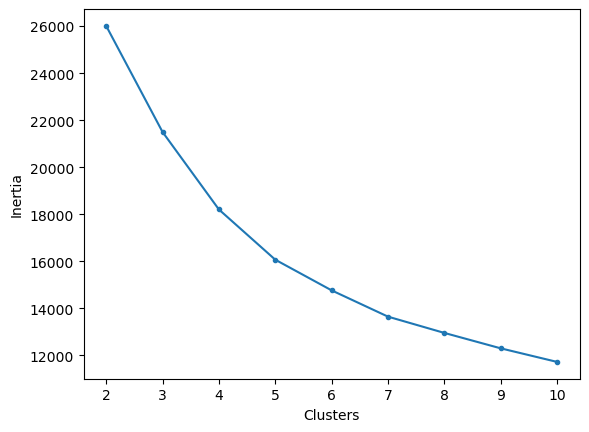

In [13]:
#Create an empty list of inertias
inertias = []
#Loop through k values between 2 and 10 and store the inertias in the list.
for k in range(2,11):
    kmeans = KMeans(n_clusters=k)  
    kmeans.fit(scaled_kmeans_df)  
    inertias.append(kmeans.inertia_)
#Visualize scores
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('Clusters')
plt.ylabel('Inertia')

The best cluster is 4 which is were the elbow occurs.

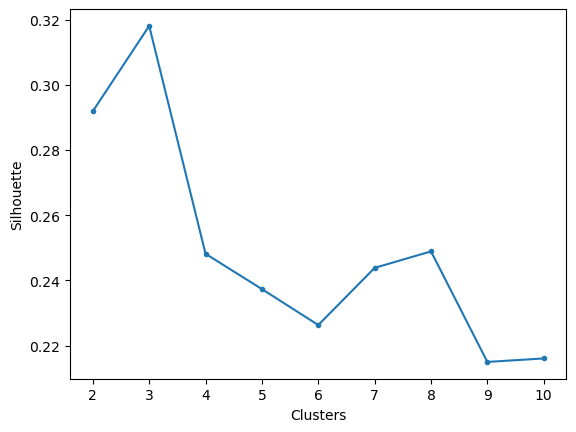

In [14]:
# Visualize different silhouette scores
# Save silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2,11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(scaled_kmeans_df)
  silhouette_scores.append(silhouette_score(scaled_kmeans_df, kmeans.labels_))
# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Clusters')
plt.ylabel('Silhouette');

The Silhouette shows at least 3 clusters. Lets try them both. 

In [15]:
#fit the KMeans model to get the Silhoutte score.
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scaled_kmeans_df)
silhouette_score(scaled_kmeans_df, kmeans.labels_)

0.3175353789086648

In [16]:
# Instantiate a Kmeans model with the best value for k based on elbow plot method and silhouette score
km = KMeans(n_clusters=3, random_state=42)
km.fit(scaled_kmeans_df)

KMeans(n_clusters=3, random_state=42)

In [17]:
df['cluster']=km.labels_

# examine your dataframe with .head()
df.head()

,SalePrice,SqFtTotLiving,SqFtTotBasement,SqFtGarageAttached,BrickStone,Bedrooms,BathFullCount,cluster
0,400000,3180,1590,600,0,6,1,1
1,474250,2200,810,0,0,4,1,0
2,667950,2525,0,400,0,4,2,1
3,659000,1820,620,0,0,3,2,0
4,656500,2310,0,440,0,3,2,1


In [18]:
# Use .groupby() to investigate the any of the statistics above for each feature in each cluster.
cluster_groups = df.groupby('cluster')
cluster_mean= cluster_groups.mean()
cluster_mean

,SalePrice,SqFtTotLiving,SqFtTotBasement,SqFtGarageAttached,BrickStone,Bedrooms,BathFullCount
cluster,,,,,,,
0,562455.276022,1537.036245,503.527571,107.034077,0.740706,2.986059,1.086431
1,870074.726055,2787.553248,742.511052,319.704622,0.953115,4.251172,1.845278
2,781486.546392,2057.680412,1023.041237,87.886598,92.876289,3.216495,1.170103


I am choosing the 3 cluster for this data. The 3 clusters differ in that they are the sum of what we have. Between 0 and 2 being so similar but having major features that make them unique. If I look at cluster 1 it has everything, bedrooms, bathrooms, living and basement space and garage room. These cluster take into consideration the amount of features and what will more likely bring more money.

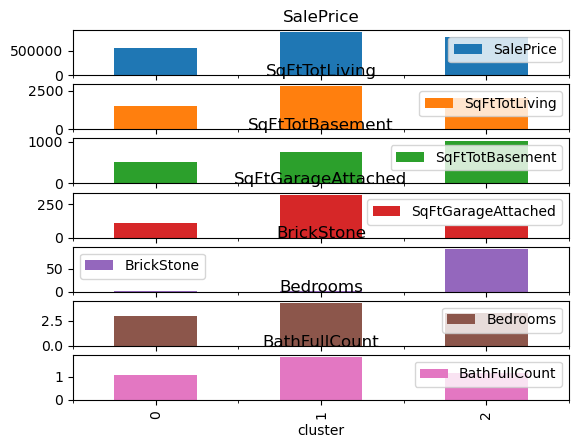

In [19]:
# Use visualizations to explore the statistics for each feature for each cluster.
cluster_mean.plot(subplots=True, kind='bar')
plt.rcParams["figure.figsize"] = (15,15)

Having this Bar plot shows the difference between these house clusters. 
0 and 2 have similar traits but 2 has Brickstone while the other doesn't. Brick/stone is more expensive for a house which makes sense on pricing.
Cluster 2 has more SqFtTotLiving and SqFtTotBasement.
Cluster 1 is the most expensive houses with very few Brick/stone homes but with more bathrooms, bathrooms, SqFtTotLiving and SqFtTotBasement.

In [20]:
#make two KMeans clusters and fit them to test out the way both cluster types look like.
kmeans4 = KMeans(n_clusters = 4)
kmeans3 = KMeans(n_clusters = 3)
kmeans4.fit(scaled_kmeans_df)
kmeans3.fit(scaled_kmeans_df)

KMeans(n_clusters=3)

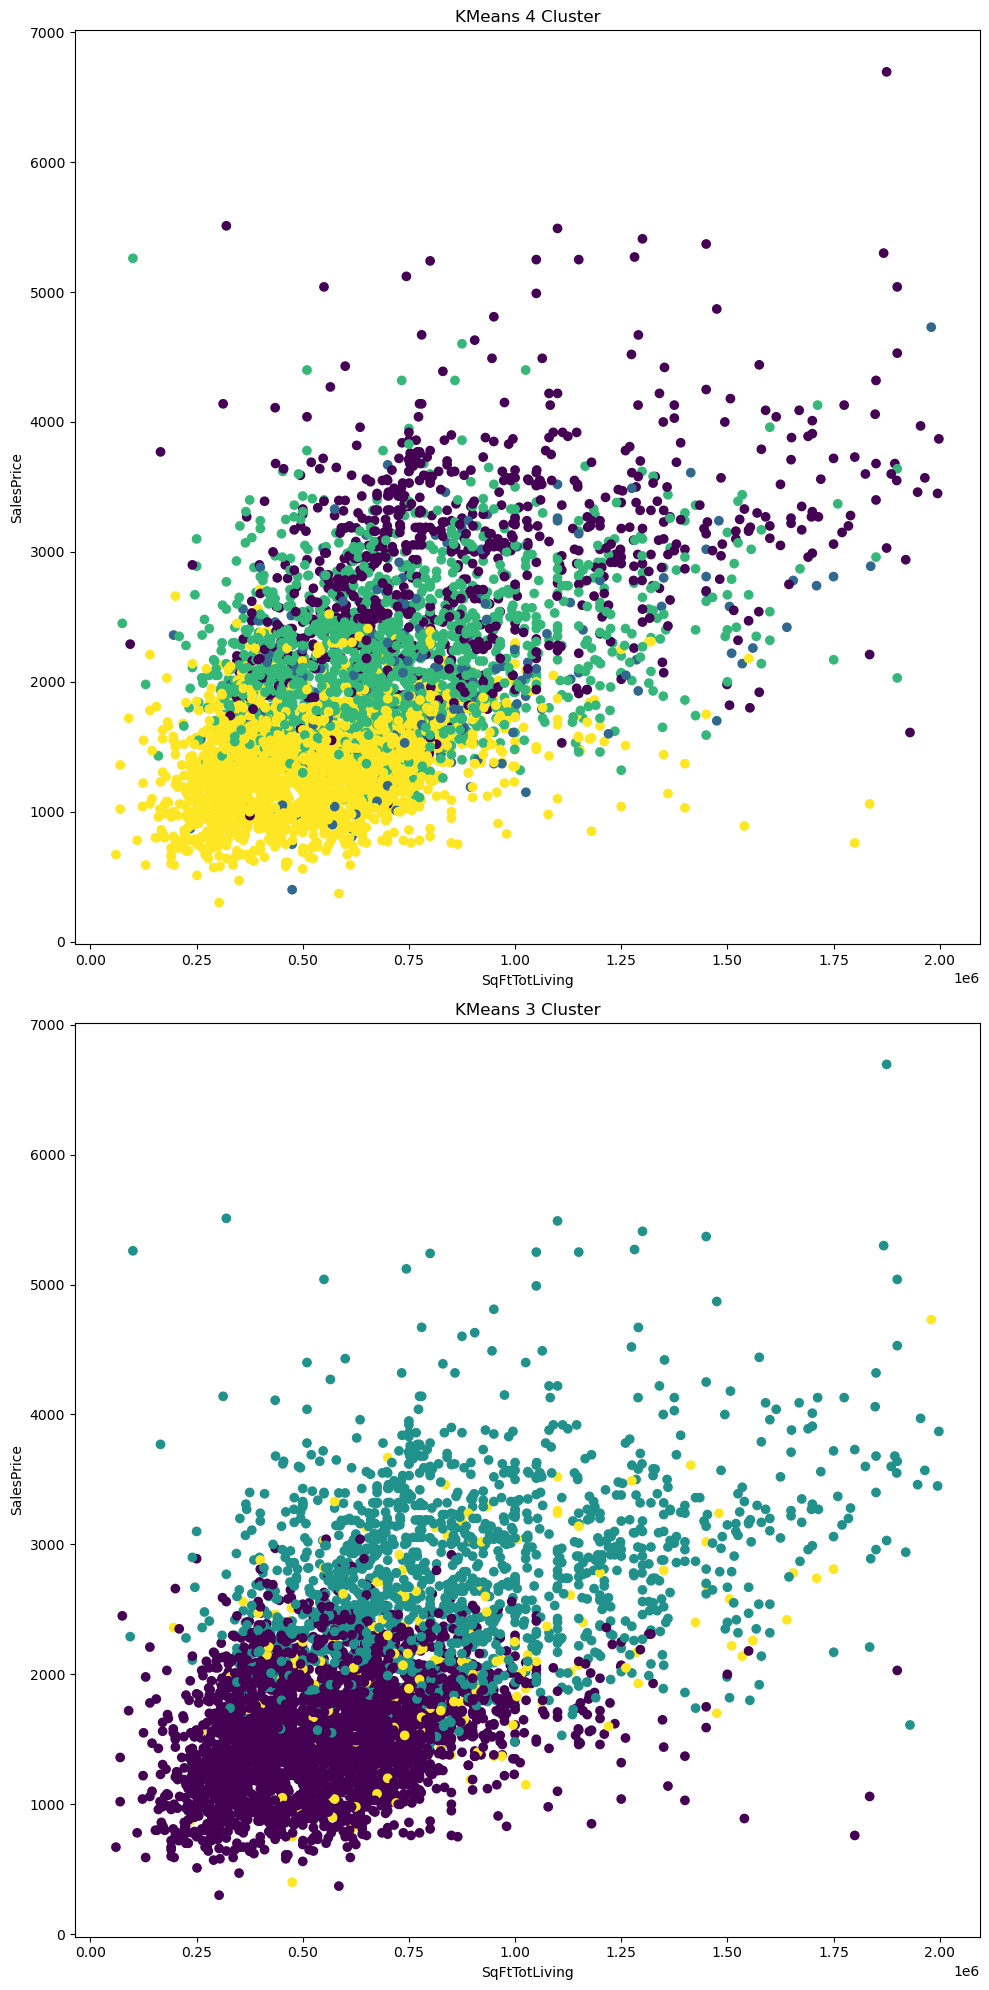

In [21]:
# Save the cluster labels to the dataframe 
kmeans_df['cluster4'] = kmeans4.labels_
kmeans_df['cluster3'] = kmeans3.labels_
# Visualize the clusters
fig, axes = plt.subplots(2,1, figsize=(10,20))
axes[0].scatter(kmeans_df['SalePrice'],kmeans_df['SqFtTotLiving'], c = kmeans_df['cluster4'])
axes[0].set_xlabel('SqFtTotLiving')
axes[0].set_ylabel('SalesPrice')
axes[0].set_title('KMeans 4 Cluster')
axes[1].scatter(kmeans_df['SalePrice'],kmeans_df['SqFtTotLiving'], c = kmeans_df['cluster3'])
axes[1].set_xlabel('SqFtTotLiving')
axes[1].set_ylabel('SalesPrice')
axes[1].set_title('KMeans 3 Cluster')
plt.tight_layout();

The cluster plot shows how much the houses blend together but there is a definite cluster between 0(Green) and 2(Yellow). 1 can be seen in dark blue. 0 and 2 clusters are so well meshed that you wouldn't be able to tell them apart otherwise. the Bar plot above really shows their similarities and differences better.

# Modeling

In [22]:
mod_df = pd.read_csv(r"F:\Coding Dojo\Data\option_A_modeling_df - option_A_modeling_df.csv")
mod_df.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,PcntComplete,Longitude,Latitude,Golf Course,Other Great Outdoors,Elementary School,General Entertainment,Park,Mexican Restaurant,Vietnamese Restaurant,Gas Station,Housing Development,Playground,Pool,Church,Dive Bar,Convenience Store,Middle School,Grocery Store,Brewery,Bar,Salon / Barbershop,Post Office,Beach,Lake,Medical Center,Sandwich Place,Nail Salon,Pizza Place,Moving Target,Building,Preschool,Library,Trail,Farm,Community Center,High School,Gym / Fitness Center,Bridge,Gym,Supermarket,School,Dance Studio,Athletics & Sports,Garden,Airport,Beer Bar,Dog Run,Pharmacy,Scenic Lookout,Bank,Fast Food Restaurant,Miscellaneous Shop,Pet Store,Doctor's Office,Pub,Coffee Shop,Food Truck,Hardware Store,Bus Stop,Field,Laundry Service,Dentist's Office,Bus Station,Auto Dealership,Veterinarian,Tennis Court,Chinese Restaurant,Furniture / Home Store,Bus Line,Café,Event Space,Italian Restaurant,Marijuana Dispensary,Office,Yoga Studio,Restaurant,Baseball Field,Discount Store,Physical Therapist,American Restaurant,Martial Arts Dojo,Spa,Storage Facility,Daycare,General Travel,Burger Joint,Pet Service,Thai Restaurant,Chiropractor,Bakery,Mobile Phone Shop,Ice Cream Shop,Automotive Shop,Assisted Living,Health & Beauty Service,Fried Chicken Joint,Taco Place,Video Store,Financial or Legal Service,Massage Studio,Asian Restaurant,Insurance Office,Japanese Restaurant,ATM,Locksmith,Shipping Store,BldgGrade_4,BldgGrade_5,BldgGrade_6,BldgGrade_7,BldgGrade_8,BldgGrade_9,BldgGrade_10,BldgGrade_11,BldgGrade_12,FinBasementGrade_3,FinBasementGrade_4,FinBasementGrade_5,FinBasementGrade_6,FinBasementGrade_7,FinBasementGrade_8,FinBasementGrade_9,FinBasementGrade_10,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,HeatSystem_8,Condition_2,Condition_3,Condition_4,Condition_5,MonthSold_02,MonthSold_03,MonthSold_04,MonthSold_05,MonthSold_06,MonthSold_07,MonthSold_08,MonthSold_09,MonthSold_10,MonthSold_11,MonthSold_12,YearSold_2017,YearSold_2018,YearSold_2019,YearSold_2020
0,400000,1590,0,0,0,3180,1590,1590,0,600,1,50,0,220,0,6,0,2,1,1965,0,-122.196399,47.336118,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,474250,1390,0,0,0,2200,810,810,0,0,1,0,0,340,0,4,1,0,1,1945,0,-122.361913,47.509874,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,667950,1010,0,1515,0,2525,0,0,0,400,0,167,0,0,0,4,1,0,2,2019,0,-122.156684,47.437557,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,659000,660,0,540,0,1820,620,620,0,0,1,0,0,100,0,3,1,0,2,2016,0,-122.370252,47.565146,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,656500,2310,0,0,0,2310,0,0,0,440,0,40,0,320,0,3,0,0,2,1967,0,-122.184194,47.730389,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0

In [23]:
mod_df.duplicated().sum()

0

In [24]:
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937 entries, 0 to 4936
Columns: 171 entries, SalePrice to YearSold_2020
dtypes: float64(2), int64(169)
memory usage: 6.4 MB


In [25]:
mod_df.isna().sum()

SalePrice         0
SqFt1stFloor      0
SqFtHalfFloor     0
SqFt2ndFloor      0
SqFtUpperFloor    0
                 ..
MonthSold_12      0
YearSold_2017     0
YearSold_2018     0
YearSold_2019     0
YearSold_2020     0
Length: 171, dtype: int64

In [26]:
mod_df.describe()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,PcntComplete,Longitude,Latitude,Golf Course,Other Great Outdoors,Elementary School,General Entertainment,Park,Mexican Restaurant,Vietnamese Restaurant,Gas Station,Housing Development,Playground,Pool,Church,Dive Bar,Convenience Store,Middle School,Grocery Store,Brewery,Bar,Salon / Barbershop,Post Office,Beach,Lake,Medical Center,Sandwich Place,Nail Salon,Pizza Place,Moving Target,Building,Preschool,Library,Trail,Farm,Community Center,High School,Gym / Fitness Center,Bridge,Gym,Supermarket,School,Dance Studio,Athletics & Sports,Garden,Airport,Beer Bar,Dog Run,Pharmacy,Scenic Lookout,Bank,Fast Food Restaurant,Miscellaneous Shop,Pet Store,Doctor's Office,Pub,Coffee Shop,Food Truck,Hardware Store,Bus Stop,Field,Laundry Service,Dentist's Office,Bus Station,Auto Dealership,Veterinarian,Tennis Court,Chinese Restaurant,Furniture / Home Store,Bus Line,Café,Event Space,Italian Restaurant,Marijuana Dispensary,Office,Yoga Studio,Restaurant,Baseball Field,Discount Store,Physical Therapist,American Restaurant,Martial Arts Dojo,Spa,Storage Facility,Daycare,General Travel,Burger Joint,Pet Service,Thai Restaurant,Chiropractor,Bakery,Mobile Phone Shop,Ice Cream Shop,Automotive Shop,Assisted Living,Health & Beauty Service,Fried Chicken Joint,Taco Place,Video Store,Financial or Legal Service,Massage Studio,Asian Restaurant,Insurance Office,Japanese Restaurant,ATM,Locksmith,Shipping Store,BldgGrade_4,BldgGrade_5,BldgGrade_6,BldgGrade_7,BldgGrade_8,BldgGrade_9,BldgGrade_10,BldgGrade_11,BldgGrade_12,FinBasementGrade_3,FinBasementGrade_4,FinBasementGrade_5,FinBasementGrade_6,FinBasementGrade_7,FinBasementGrade_8,FinBasementGrade_9,FinBasementGrade_10,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,HeatSystem_8,Condition_2,Condition_3,Condition_4,Condition_5,MonthSold_02,MonthSold_03,MonthSold_04,MonthSold_05,MonthSold_06,MonthSold_07,MonthSold_08,MonthSold_09,MonthSold_10,MonthSold_11,MonthSold_12,YearSold_2017,YearSold_2018,YearSold_2019,YearSold_2020
count,4.937000e+03,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.00000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.00

In [27]:
# I removed these columns because they were not used in the kmeans data and were irrelevent to my project.
mod_df= mod_df.drop(columns=['SqFt1stFloor','SqFtHalfFloor','SqFt2ndFloor','SqFtUpperFloor','DaylightBasement',
                     'SqFtFinBasement','SqFtGarageBasement','SqFtOpenPorch','SqFtEnclosedPorch','SqFtDeck',
                     'BathHalfCount','Bath3qtrCount','Longitude','Latitude','YrBuilt'])

In [28]:
#make a copy of data. Incase I mess up.
belt_df = mod_df.copy()

Preparing for Modeling

In [29]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics
def model_metrics(pipe, X_train, y_train, X_test, y_test, 
                       model_name='Regression Model', ):
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)
  
  metrics = ['train_MAE','test_MAE', 
             'train_RMSE', 'test_RMSE', 
             'train_R2', 'test_R2']
  
  ## Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),7)

  ## Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),7)

  ## Output Dataframe
  scores = pd.DataFrame(index=metrics, columns=[f'{model_name}_test'])
  scores.loc[metrics, f'{model_name}_test'] = [train_mae, test_mae,
                                               train_rmse, test_rmse,
                                               train_r2, test_r2]

  return scores

In [30]:
#Target
target = 'SalePrice'
X = belt_df.drop(columns = [target])
y = belt_df[target]

In [31]:
mod_scaler = scaler.fit_transform(X)
mod_scaler

array([[ 1.62644649e+00,  1.75297097e+00,  1.79217016e+00, ...,
        -5.29160062e-01, -6.08791778e-01, -1.36265133e-01],
       [ 3.45249476e-01,  3.77782981e-01, -7.11108884e-01, ...,
         1.88978737e+00, -6.08791778e-01, -1.36265133e-01],
       [ 7.70136241e-01, -1.05029685e+00,  9.57743814e-01, ...,
        -5.29160062e-01,  1.64259774e+00, -1.36265133e-01],
       ...,
       [-4.52230298e-01,  1.22405251e+00, -1.84648731e-03, ...,
        -5.29160062e-01,  1.64259774e+00, -1.36265133e-01],
       [ 8.68187033e-01,  1.24168313e+00, -7.11108884e-01, ...,
        -5.29160062e-01,  1.64259774e+00, -1.36265133e-01],
       [ 1.43034491e+00, -1.05029685e+00,  1.24979304e+00, ...,
        -5.29160062e-01, -6.08791778e-01, -1.36265133e-01]])

# PCA

In [32]:
pca = PCA()
pca.fit(mod_scaler)

PCA()

In [33]:
pd.Series(pca.explained_variance_ratio_) 

0      0.023374
1      0.022072
2      0.016560
3      0.014679
4      0.013147
         ...   
150    0.000930
151    0.000348
152    0.000022
153    0.000002
154    0.000002
Length: 155, dtype: float64

C:\Users\miran\AppData\Local\Temp\ipykernel_18868\1229442249.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


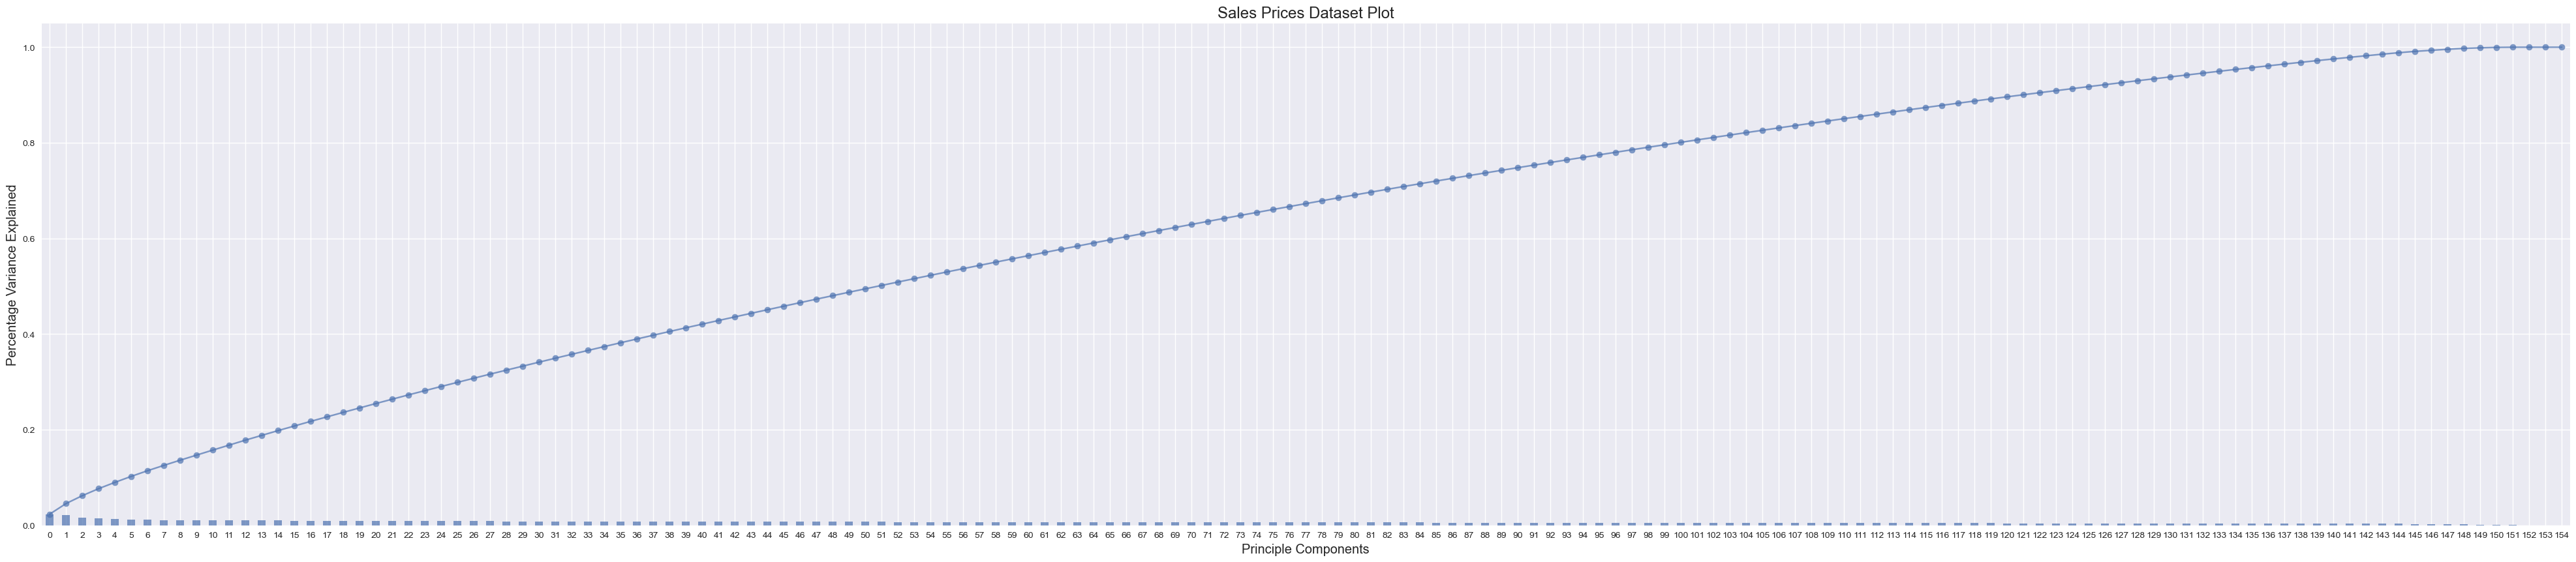

In [34]:
# Lets visual the cummulative sum of the variances 

plt.style.use("seaborn")
plt.figure(figsize=(50,10))
exp_var = pd.Series(pca.explained_variance_ratio_)

# Plot the variance for each component
exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total = total+x
    var_ls.append(total)
    
# Plot line chart of increasing variances
plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Sales Prices Dataset Plot", fontsize="xx-large")
pd.Series(var_ls).plot(marker="o", alpha=0.7) 
plt.xticks(rotation=0)
plt.show();

In [35]:
# Split train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [36]:
# Fit & transform data
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [37]:
# fit PCA
pca = PCA (n_components= 128)
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

# Created two model to compare training time

rf = RandomForestRegressor(random_state = 42)

In [44]:
# Measure how long it takes to train
rf.fit(X_train_pca, y_train)

# Checking the accurancy of our model with PCA 
print('Training accuracy', rf.score(X_train_pca, y_train))
print('Testing accuracy:', rf.score(X_test_pca, y_test))

Training accuracy 0.9273536744167478
Testing accuracy: 0.4529223782062721


In [45]:
rf_pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=128),
    RandomForestRegressor(random_state = 42))   

In [46]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('pca', PCA(n_components=128)),
  ('randomforestregressor', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'pca': PCA(n_components=128),
 'randomforestregressor': RandomForestRegressor(random_state=42),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 128,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__criterion': 'squared_error',
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 1.0,
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_samples': None,
 'random

In [47]:
# Creating param_grid
rf_param_grid = { "pca__n_components": range(128,138),                 
                 "randomforestregressor__max_depth": range (1,34),
                 "randomforestregressor__n_estimators": range(300,500)}

In [ ]:
rf_reg_pipe_gs = GridSearchCV(rf_pipe, rf_param_grid)

rf_reg_pipe_gs.fit(X_train, y_train)
print('Best Random Forest Parameters: ')
print(rf_reg_pipe_gs.best_params_)
rf_best_pipe = rf_pipe_gs.best_estimator_
print(f'Accuracy of best Random Forest model is: {rf_best_pipe.score(X_test, y_test)}')

In [ ]:
rf_pipe.fit(X_train,y_train)
rf_pipe.score(X_test,y_test)

In [ ]:
rf_grid_df = pd.DataFrame(rf_reg_pipe_gs.cv_results_)

rf_grid_df 

In [ ]:
%load_ext jupyternotify

In [ ]:
%%notify
import time
time.sleep(10)
print('Finished!')

In [ ]:
parameters = ['pca__n_components','randomforestregressor__max_depth','randomforestregressor__n_estimators']

rf_grid_df[parameters]

In [ ]:
rf_grid_df[parameters].sort_values(by = ['rank_test_score'])

In [ ]:
rf_grid.best_params_

In [ ]:
# Lets choose all the 80 models that ranked 1st 
best_rf = rf_grid_df[parameters].sort_values(by = ['rank_test_score']).head(80)

best_rf.head()

In [ ]:
# lets sort those by the PCAs to choose the least number of components
best_rf.sort_values(by = ['param_pca__n_components']).head(10)

In [ ]:
best_rf['param_pca__n_components'].value_counts()

In [ ]:
# Best Scoring Model
rf_grid.best_rf_score_

In [ ]:
# Lets use the best model to predict our values
pred = rf_grid.best_rf_estimator_.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
plot_confusion_matrix(rf_grid, X_test, y_test)
plt.rf_grid(False);

## Sequential model

In [ ]:
# Build your model
shape_input = rf_best_pipe.shape[1]

# Instentiate the model
class_model = Sequential()

# create the first layer with input as the no of features in dataset
class_model.add(Dense(10, activation = 'relu', input_dim = shape_input))

# Create hidden layers
class_model.add(Dense(10, activation = 'relu'))

# Create output layer 
# Since this is a binary classification
# The activation function of our final layer needs to be 'sigmoid'. 
class_model.add(Dense(1, activation = 'sigmoid'))

### I have been unable to complete the exam and couldn't get past the grid search. I would like to try it again. Thank you.